In [1]:
%load_ext autoreload
%autoreload 2

Namespace(aux_loss=False, backbone='resnet50', batch_size=1, bbox_loss_coef=5, cache_mode=False, clip_max_norm=0.1, cls_loss_coef=2, coco_panoptic_path=None, coco_path='/root/dataset_clp/', dataset_file='coco', dec_layers=6, dec_n_points=4, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=1024, dropout=0.1, enc_layers=6, enc_n_points=4, epochs=100, eval=True, focal_alpha=0.25, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0002, lr_backbone=2e-05, lr_backbone_names=['backbone.0'], lr_drop=40, lr_drop_epochs=None, lr_linear_proj_mult=0.1, lr_linear_proj_names=['reference_points', 'sampling_offsets'], mask_loss_coef=1, masks=False, nheads=8, num_feature_levels=4, num_queries=300, num_workers=8, output_dir='result', position_embedding='sine', position_embedding_scale=6.283185307179586, remove_difficult=False, resume='', seed=42, set_cost_bbox=5, set_cost_class=2, set_cost_giou=2, sgd=False, start_epoch=0, two_stage=True, visualize_reference_point=True, weight_

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:565: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/BinaryOps.cpp:506.)
  return torch.floor_divide(self, other)


input feature map from backbone : torch.Size([1, 512, 380, 504])
input feature map from backbone : torch.Size([1, 1024, 190, 252])
input feature map from backbone : torch.Size([1, 2048, 95, 126])
(3024,)
scatter h=0, l=3, k=0
(3024,)
scatter h=0, l=3, k=1
(3024,)
scatter h=0, l=3, k=2
(3024,)
scatter h=0, l=3, k=3
Encdoer Layer 0/lvl_3's sampling point save
(3024,)
scatter h=0, l=3, k=0
(3024,)
scatter h=0, l=3, k=1
(3024,)
scatter h=0, l=3, k=2
(3024,)
scatter h=0, l=3, k=3
Encdoer Layer 1/lvl_3's sampling point save
(3024,)
scatter h=0, l=3, k=0
(3024,)
scatter h=0, l=3, k=1
(3024,)
scatter h=0, l=3, k=2
(3024,)
scatter h=0, l=3, k=3
Encdoer Layer 2/lvl_3's sampling point save
(3024,)
scatter h=0, l=3, k=0
(3024,)
scatter h=0, l=3, k=1
(3024,)
scatter h=0, l=3, k=2
(3024,)
scatter h=0, l=3, k=3
Encdoer Layer 3/lvl_3's sampling point save
(3024,)
scatter h=0, l=3, k=0
(3024,)
scatter h=0, l=3, k=1
(3024,)
scatter h=0, l=3, k=2
(3024,)
scatter h=0, l=3, k=3
Encdoer Layer 4/lvl_3's samp

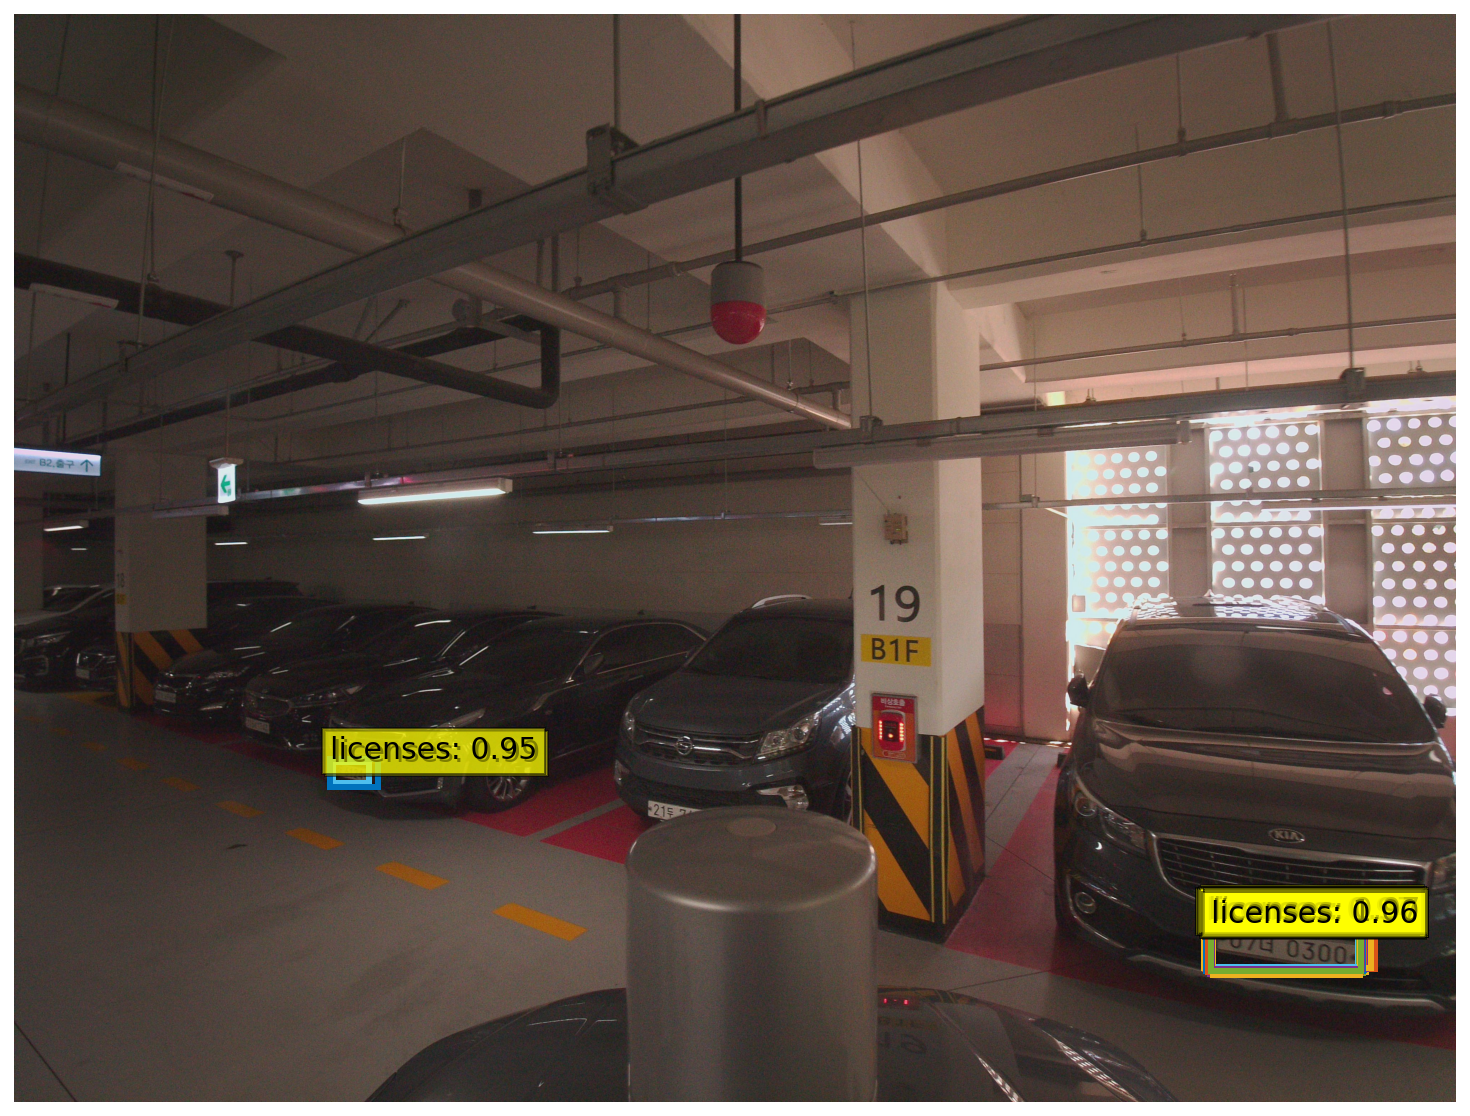

In [2]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import argparse
import test
import torchvision
from pathlib import Path
from models.deformable_detr import build
from models.deformable_detr import DeformableDETR
from util.misc import NestedTensor
torch.set_grad_enabled(False);

# COCO classes
CLASSES = [
    'N/A', 'licenses'
]

# box colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# img processing
transform = T.Compose([
    # T.Resize((800,800)),
    T.ToTensor(),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32, device=device)
    return b
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# 기본적인 옵션을 설정
# 만약 two-stage region proposal 사용 시 "--with_box_refine --two_stage --faster_rcnn" 옵션을 추가
# two-stage region proposal 사용을 안한다면 해당 옵션 제거
# --visualize_reference_point를 추가하면 reference point 시각화 코드가 활성화됨
# 샘플링포인트와 reference_point는 result_sampling에 저장됨
command ="--dataset_file coco --coco_path /root/dataset_clp/ --output_dir result --with_box_refine --two_stage --batch_size 1 --eval --no_aux_loss --num_workers=8 --visualize_reference_point"

parser = argparse.ArgumentParser('Deformable DETR training and evaluation script', parents=[test.get_args_parser()])
args = parser.parse_args(command.split())

print(args)

device = torch.device('cuda')
# 타겟 이미지 경로 설정
im = Image.open('/root/pytorch-faster-rcnn/imgs/20220901_105528_41.jpg')

img = transform(im).unsqueeze(0)
img = img.to(device)  # 입력 데이터를 CUDA 디바이스로 이동

# FasterRCNN
# from utils_rcnn.train_utils import create_model
# from configs.test_config import test_cfg
# faster_rcnn = create_model(num_classes=test_cfg.num_classes)
# faster_rcnn.to(args.device)
# weights = test_cfg.model_weights

# checkpoint = torch.load(weights, map_location='cpu')
# faster_rcnn.load_state_dict(checkpoint['model'])
# faster_rcnn.eval()
# predictions, bf_nms_boxes, pred_boxes = faster_rcnn(img)

# Deformable DETR
model, criterion, postprocessors = build(args)

# 각 가중치의 경로를 입력
if args.two_stage :
    state_dict = torch.load('/root/Deformable-DETR/exps/r50_deformable_detr_plus_iterative_bbox_refinement_plus_plus_two_stage/checkpoint0044.pth')
else : 
    state_dict = torch.load('deformable detr pth 경로')

model.load_state_dict(state_dict['model'])
model.to(device)

# propagate through the model
outputs = model(img, None)

# keep only predictions with 0.7+ confidence
probas = outputs[0]['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs[0]['pred_boxes'][0, keep], im.size, device)
plot_results(im, probas[keep], bboxes_scaled)

### 시각화를 위한 hook

In [9]:
def hooking(model, layer=-1) :# use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights, dec_reference_points = [], [], [], []
    feature_backbone = []
    encoder_layer = layer
    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[encoder_layer].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[0])
        ),
        model.transformer.decoder.layers[-1].cross_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
        model.transformer.decoder.register_forward_hook(
            lambda self, input, output: dec_reference_points.append(output[1])
        ),
        model.backbone.register_forward_hook(
            lambda self, input, output: feature_backbone.append(output[0])
        ),
    ]

    # propagate through the model
    outputs = model(img, None)

    for hook in hooks:
        hook.remove()
        

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]
    feature_backbone = feature_backbone

In [18]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights, dec_reference_points, init_refer_bf_two_stage = [], [], [], [], []
feature_backbone = []
encoder_layer = -1
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[encoder_layer].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[0])
    ),
    model.transformer.decoder.layers[-1].cross_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[0])
    ),
    model.transformer.register_forward_hook(
        lambda self, input, output: dec_reference_points.append(output[2])
    ),
    model.transformer.register_forward_hook(
        lambda self, input, output: init_refer_bf_two_stage.append(output[1])
    ),
    model.backbone.register_forward_hook(
        lambda self, input, output: feature_backbone.append(output[0])
    ),
]

# propagate through the model
outputs = model(img, None)

for hook in hooks:
    hook.remove()
    

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]
dec_reference_points = dec_reference_points[0]
init_refer_bf_two_stage = init_refer_bf_two_stage[0]
feature_backbone = feature_backbone[0]

print(f'dec_attn_weights {dec_attn_weights.shape}')
print(f'dec_rf_point {dec_reference_points.shape}')
print(f'init_refer_bf_two_stage {init_refer_bf_two_stage.shape}')


input feature map from backbone : torch.Size([1, 512, 380, 504])
input feature map from backbone : torch.Size([1, 1024, 190, 252])
input feature map from backbone : torch.Size([1, 2048, 95, 126])
feature_backbone [tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.2300e-03,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[2.4118e-01, 1.0350e-01, 7.4302e-02,  ..., 1.2370e-01,
           9.6916e-02, 2.7575e-01],
          [1.5785e-01, 2.4000e-01, 2.1818e-01,  ..., 3.1477e-0

### Decoder의 입력으로 들어가게 되는 reference point를 시각화  
- origin deformable detr : x,y좌표로 이루어진 scatter
- two stage : 바운딩 박스 

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

In [12]:
# 원본 이미지의 크기를 가져옵니다.
dec_reference_points = dec_reference_points.detach().cpu()
img_width, img_height = im.size
if dec_reference_points.shape[-1] == 4 :
    # 모든 head에 대해
    for i in range(6):
        fig, axs = plt.subplots(1, figsize=(10, 10))
        axs.imshow(im)

        # 각 바운딩 박스에 대해
        for idx, bbox in enumerate(dec_reference_points[i, 0]):
            # 상대 좌표를 원본 이미지의 크기에 맞게 변환
            x, y, w, h = bbox
            x = x * img_width
            w = w * img_width
            y = y * img_height
            h = h * img_height
            
            # 변환된 좌표를 이용해 사각형 패치 생성
            rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')

            # 사각형 패치 추가
            axs.add_patch(rect)
            if idx == 299 : 
                print(f'{i}_layer pass')
                print(f'input image shape : {im.size}')
                print(dec_reference_points[i, 0].shape)

        # 이미지 저장
        plt.title(f"layer_{i}")
        plt.savefig(f'/root/Deformable-DETR/result_decoder_boxes/two_stage_bbox_dec_layer_{i}.png')
        plt.close()
else :
    # 모든 head에 대해
    for i in range(6):
        fig, axs = plt.subplots(1, figsize=(10, 10))
        axs.imshow(im)

        # 각 바운딩 박스에 대해
        for idx, x_y_ in enumerate(dec_reference_points[i, 0]):
            # 상대 좌표를 원본 이미지의 크기에 맞게 변환
            x, y = x_y_
            x = x * img_width
            y = y * img_height
            # 변환된 좌표를 이용해 사각형 패치 생성
            axs.scatter(x, y, s=3, color='skyblue')

            if idx == 299 : 
                print(f'{i}_layer pass')
                print(f'input image shape : {im.size}')
                print(dec_reference_points[i, 0].shape)

        # 이미지 저장
        plt.title(f"layer_{i}")
        plt.savefig(f'/root/Deformable-DETR/result_decoder_boxes/dec_rf_point_layer_{i}.png')
        plt.close()

(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass
(4032, 3040)
torch.Size([300, 4])
layer pass


### Decoder를 통과하고 난 후, reference point 시각화
- origin deformable detr : x,y좌표로 이루어진 scatter
- two stage : 바운딩 박스 
- 멀티스케일이 아닌 하나의 스케일로만 이루어짐

In [ ]:
# 원본 이미지의 크기를 가져옵니다.
# init_refer_bf_two_stage -> [1,300,4]
init_refer_bf_two_stage = init_refer_bf_two_stage.detach().cpu()
img_width, img_height = im.size
# 모든 head에 대해
fig, axs = plt.subplots(1, figsize=(10, 10))
axs.imshow(im)

# 각 바운딩 박스에 대해
for idx, bbox in enumerate(init_refer_bf_two_stage[0]):
    # 상대 좌표를 원본 이미지의 크기에 맞게 변환
    x, y, w, h = bbox
    x = x * img_width
    w = w * img_width
    y = y * img_height
    h = h * img_height
    
    # 변환된 좌표를 이용해 사각형 패치 생성
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')

    # 사각형 패치 추가
    axs.add_patch(rect)
    if idx == 299 : 
        print(f'{i}_layer pass')
        print(f'input image shape : {im.size}')
        print('layer pass')

    # 이미지 저장
plt.title(f"two-stage-region-proposal")
plt.savefig(f'/root/Deformable-DETR/result_decoder_boxes/two-stage-region-proposal.png')
plt.close()


(4032, 3040)
torch.Size([300, 4])
layer pass


# Visualize encoder self-attention weights

- Encoder의 Attention을 시각화하는 코드

In [19]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([254394, 256])
Feature map:             torch.Size([1, 512, 380, 504])


### Encoder Attention weight 시각화 코드
- seaborn을 이용

input feature map from backbone : torch.Size([1, 512, 380, 504])
input feature map from backbone : torch.Size([1, 1024, 190, 252])
input feature map from backbone : torch.Size([1, 2048, 95, 126])
11970


/tmp/ipykernel_10474/1501084742.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mean_feature = F.softmax(mean_feature)


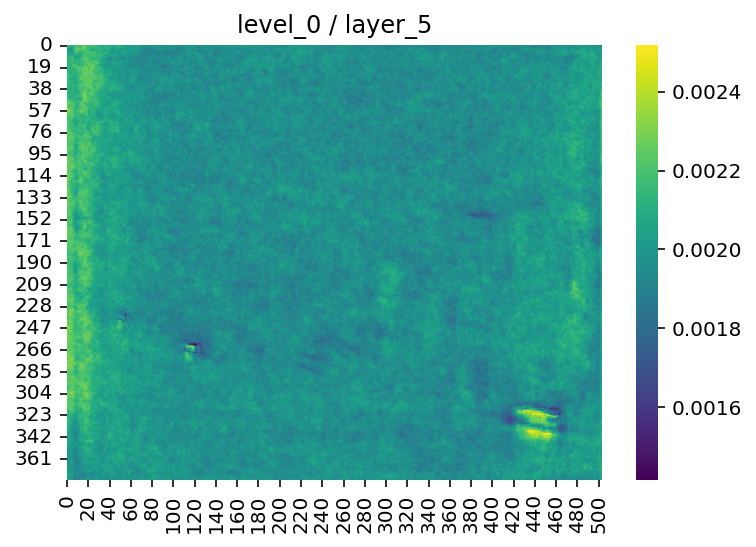

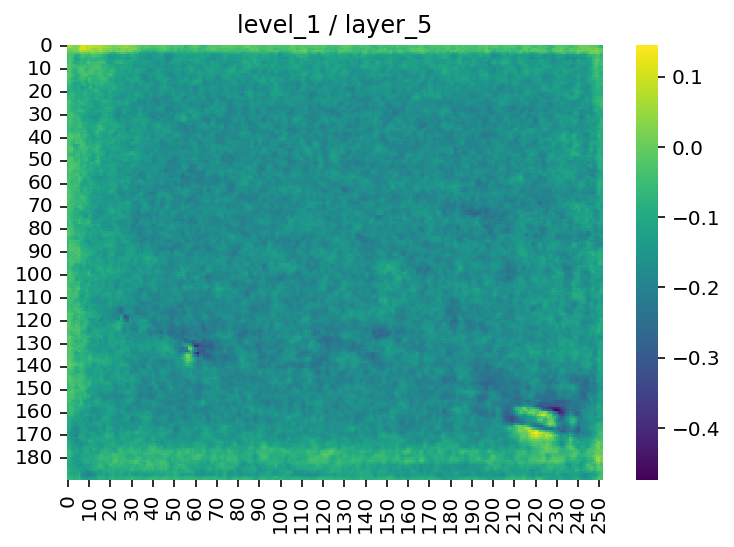

/tmp/ipykernel_10474/1501084742.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mean_feature = F.softmax(mean_feature)


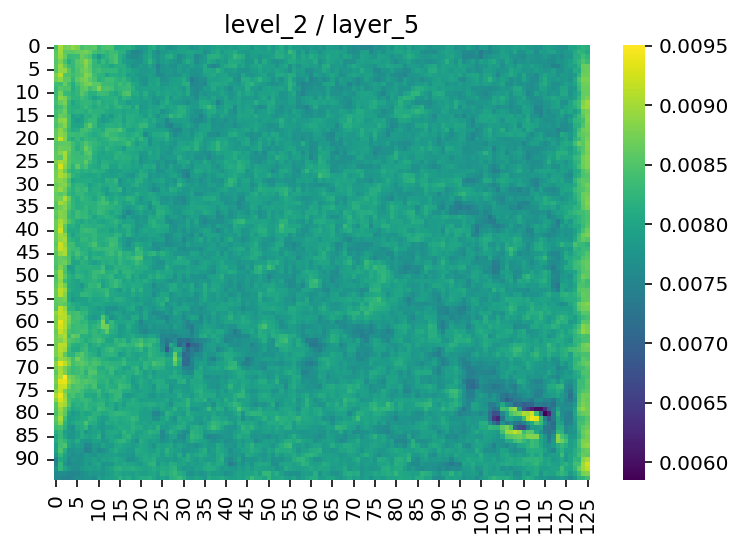

In [34]:
import seaborn as sns
import torch.nn.functional as F
import math 
# 출력하고 저장할 인코더 레이어의 수를 지정해줄 것
encoder_layer = 5

hooking(model, encoder_layer)

split_sizes = [] 
h_list = []
w_list = []

for key, feature in conv_features.items() :
    h = feature.tensors.shape[2]
    w = feature.tensors.shape[3]
    h_list.append(h)
    w_list.append(w)
    split_sizes.append(h*w)
# 만약 피처맵의 개수가 더 많다면 아래 작업을 진행 (4개를 가정하고 하였음)
if enc_attn_weights[0].shape[0] > sum(split_sizes) :
    print(split_sizes[-1])
    h_list.append(math.ceil(h_list[-1] / 2))
    w_list.append(math.ceil(w_list[-1] / 2))
    new_size = h_list[-1] * w_list[-1]
    split_sizes.append(new_size)

f1, f2, f3, f4 = torch.split(enc_attn_weights[0], split_sizes, dim=0)
for key, feature in conv_features.items() :
    # get the HxW shape of the feature maps of the CNN
    shape = feature.tensors.shape[-2:]
    if key == '0':
        f1 = f1.reshape(conv_features[key].tensors.shape[2], conv_features[key].tensors.shape[3], 256)
        mean_feature = f1.mean(dim=2)
        mean_feature = F.softmax(mean_feature)
    elif key == '1' :
        f2 = f2.reshape(conv_features[key].tensors.shape[2], conv_features[key].tensors.shape[3], 256)
        mean_feature = f2.mean(dim=2)
    elif key == '2' :
        f3 = f3.reshape(conv_features[key].tensors.shape[2], conv_features[key].tensors.shape[3], 256)
        mean_feature = f3.mean(dim=2)
        mean_feature = F.softmax(mean_feature)
    else : mean_feature = None
    
    if mean_feature != None :
        sns.heatmap(mean_feature.cpu(), cmap='viridis')
        plt.title(f'level_{key} / layer_{encoder_layer}')
        plt.savefig(f'/root/Deformable-DETR/result_attention/encoder_two_stage/layer_{encoder_layer}_level_{key}.jpg')
        plt.show()
        plt.close()
